# SIECI NEURONOWE – ćwiczenie 6

W ćwiczeniu 6 należy zbudować sieć wykorzystującą warstwy CNN i operator max pooling. Warstwa CNN dostępna jest w torch.nn. 

Conv2d:

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

Warstwa przyjmuje 4-wymiarowe wejścia (batch, kanały obrazka, wysokość, szerokość). Dla obrazków czarno-białych liczba kanałów wejścia będzie równa 1, liczba kanałów wyjściowych powinna być większa. Po przejściu przez jedną lub więcej warstw konwolucyjnych, wyjście trzeba spłaszczyć i podać do warstwy liniowej, dalej skorzystać ze standardowej dla klasyfikacji funkcji kosztu. Do implementacji warstwy liniowej można skorzystać z LazyLinear, która automatycznie ustala wymiarowość przy pierwszym przejściu danych.

Do przebadania będzie
- Liczba kanałów wyjściowych warstwy konwolucyjnej
- Rozmiar filtra warstwy konwolucyjnej
- Rozmiar okna poolingu
- Zaburzenia danych: dane można zaburzyć dodając do wejściowego batcha. Batch o tych samych wymiarach, wygenerowany jako szum gaussowski o różnych odchyleniach. Przebadać scenariusze: szum dodany w danych testowych vs szum dodany zarówno w testowych, jak i treningowych.

Ćwiczenie oceniane jest w skali 0-10 pkt, na jego wykonanie są 2 tygodnie.

## Inicjacja

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

batch_size = 64
num_epochs = 3 
learning_rate = 0.001

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def add_noise(batch, std):
    return batch + torch.randn_like(batch) * std

## Definicja NN

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, conv1_out, conv2_out, kernel_size, pool_size):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, conv1_out, kernel_size=kernel_size, padding=kernel_size//2)
        self.conv2 = nn.Conv2d(conv1_out, conv2_out, kernel_size=kernel_size, padding=kernel_size//2)
        self.pool = nn.MaxPool2d(pool_size, pool_size)
        self.flatten = nn.Flatten()
        self.fc = nn.LazyLinear(10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.fc(x)
        return x



## Eksperyment

In [ ]:
conv_channels = [(8, 16), (16, 32)]
kernel_sizes = [3, 5]
pool_sizes = [2, 3]
noise_configs = [
    (0.0, 0.0),
    (0.1, 0.0),
    (0.1, 0.1),
    (0.0, 0.1)
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = []

for (c1, c2), k, p, (noise_train, noise_test) in itertools.product(conv_channels, kernel_sizes, pool_sizes, noise_configs):
    model = SimpleCNN(c1, c2, k, p).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Trening
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs_noisy = add_noise(inputs, noise_train)
            optimizer.zero_grad()
            outputs = model(inputs_noisy)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    # Ocena Modelu
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs_noisy = add_noise(inputs, noise_test)
            outputs = model(inputs_noisy)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    acc = correct / total
    results.append({
        "conv_channels": f"{c1}-{c2}",
        "kernel_size": k,
        "pool_size": p,
        "noise_train": noise_train,
        "noise_test": noise_test,
        "accuracy": acc
    })
    print(f"Tested: conv={c1}-{c2}, kernel={k}, pool={p}, noise_train={noise_train}, noise_test={noise_test}, acc={acc:.2f}")

# Tabela wyników    
df = pd.DataFrame(results)
print("\nWyniki eksperymentu:")
print(df)


Tested: conv=8-16, kernel=3, pool=2, noise_train=0.0, noise_test=0.0, acc=0.87
Tested: conv=8-16, kernel=3, pool=2, noise_train=0.1, noise_test=0.0, acc=0.87
Tested: conv=8-16, kernel=3, pool=2, noise_train=0.1, noise_test=0.1, acc=0.85
Tested: conv=8-16, kernel=3, pool=2, noise_train=0.0, noise_test=0.1, acc=0.80
Tested: conv=8-16, kernel=3, pool=3, noise_train=0.0, noise_test=0.0, acc=0.84
Tested: conv=8-16, kernel=3, pool=3, noise_train=0.1, noise_test=0.0, acc=0.82
Tested: conv=8-16, kernel=3, pool=3, noise_train=0.1, noise_test=0.1, acc=0.82
Tested: conv=8-16, kernel=3, pool=3, noise_train=0.0, noise_test=0.1, acc=0.79
Tested: conv=8-16, kernel=5, pool=2, noise_train=0.0, noise_test=0.0, acc=0.87
Tested: conv=8-16, kernel=5, pool=2, noise_train=0.1, noise_test=0.0, acc=0.88
Tested: conv=8-16, kernel=5, pool=2, noise_train=0.1, noise_test=0.1, acc=0.87
Tested: conv=8-16, kernel=5, pool=2, noise_train=0.0, noise_test=0.1, acc=0.86
Tested: conv=8-16, kernel=5, pool=3, noise_train=0.0

## Generacja wykresów

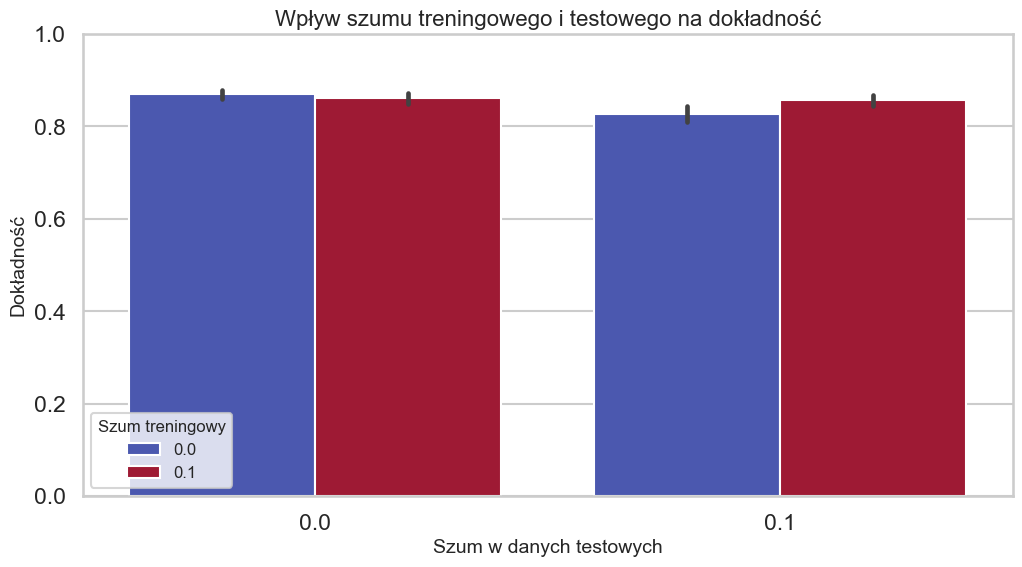

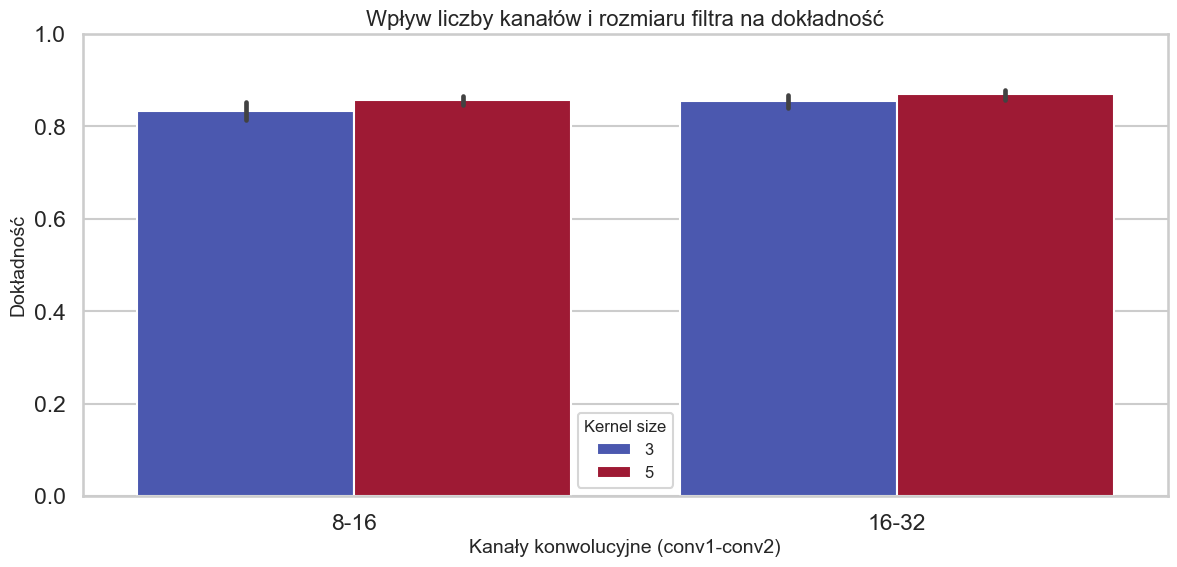

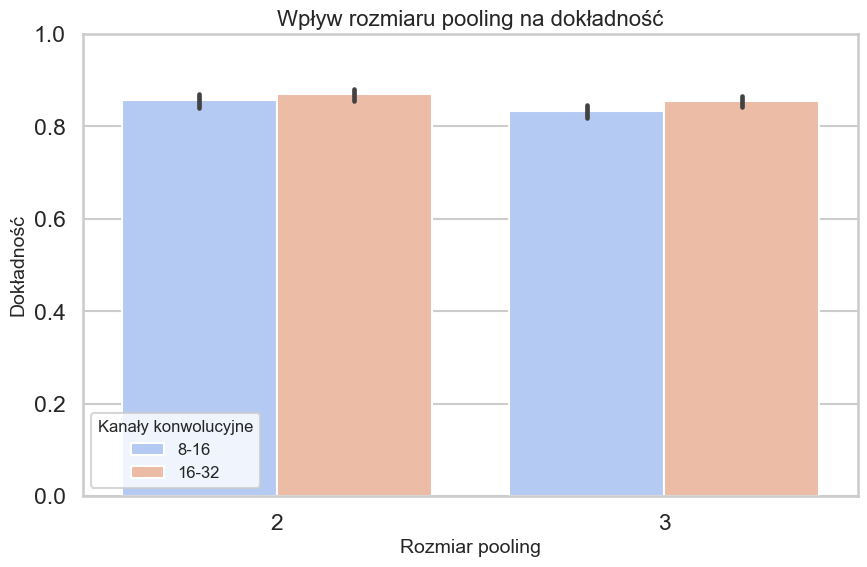

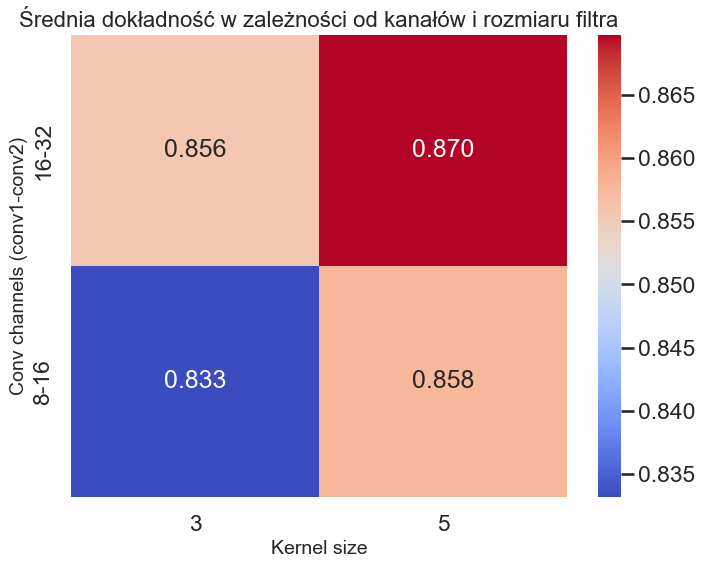

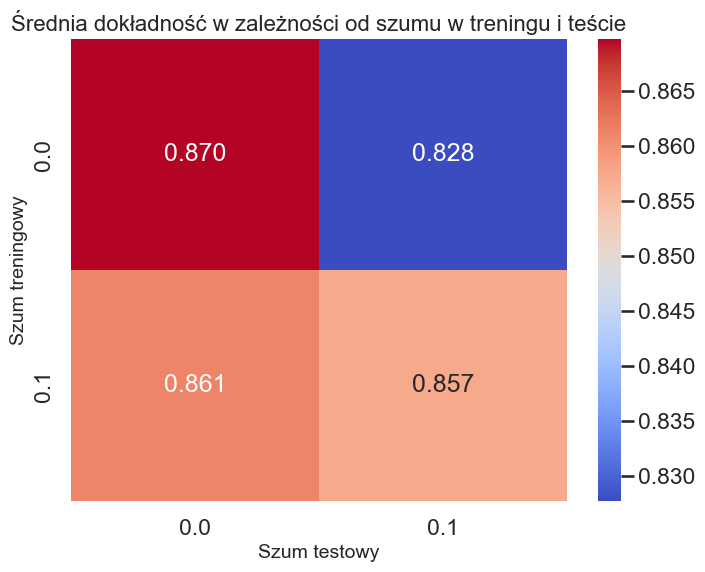

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ustawienia stylu
sns.set_style("whitegrid")
sns.set_context("talk")
palette = "coolwarm"

# Wykres: wpływ szumu na dokładność
plt.figure(figsize=(12,6))
sns.barplot(x="noise_test", y="accuracy", hue="noise_train", data=df, palette=palette)
plt.title("Wpływ szumu treningowego i testowego na dokładność", fontsize=16)
plt.xlabel("Szum w danych testowych", fontsize=14)
plt.ylabel("Dokładność", fontsize=14)
plt.legend(title="Szum treningowy", fontsize=12, title_fontsize=12)
plt.ylim(0, 1)
plt.show()

# Wykres: wpływ konfiguracji CNN na dokładność
plt.figure(figsize=(14,6))
sns.barplot(x="conv_channels", y="accuracy", hue="kernel_size", data=df, palette=palette)
plt.title("Wpływ liczby kanałów i rozmiaru filtra na dokładność", fontsize=16)
plt.xlabel("Kanały konwolucyjne (conv1-conv2)", fontsize=14)
plt.ylabel("Dokładność", fontsize=14)
plt.legend(title="Kernel size", fontsize=12, title_fontsize=12)
plt.ylim(0, 1)
plt.show()

# Wykres: wpływ rozmiaru pooling
plt.figure(figsize=(10,6))
sns.barplot(x="pool_size", y="accuracy", hue="conv_channels", data=df, palette=palette)
plt.title("Wpływ rozmiaru pooling na dokładność", fontsize=16)
plt.xlabel("Rozmiar pooling", fontsize=14)
plt.ylabel("Dokładność", fontsize=14)
plt.legend(title="Kanały konwolucyjne", fontsize=12, title_fontsize=12)
plt.ylim(0, 1)
plt.show()

# Heatmapa dokładności: kanały i filtry
pivot_table = df.pivot_table(values='accuracy', index='conv_channels', columns='kernel_size', aggfunc='mean')
plt.figure(figsize=(8,6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap=palette, cbar=True)
plt.title("Średnia dokładność w zależności od kanałów i rozmiaru filtra", fontsize=16)
plt.xlabel("Kernel size", fontsize=14)
plt.ylabel("Conv channels (conv1-conv2)", fontsize=14)
plt.show()

# Heatmapa dokładności: szum treningowy i testowy
pivot_noise = df.pivot_table(values='accuracy', index='noise_train', columns='noise_test', aggfunc='mean')
plt.figure(figsize=(8,6))
sns.heatmap(pivot_noise, annot=True, fmt=".3f", cmap=palette, cbar=True)
plt.title("Średnia dokładność w zależności od szumu w treningu i teście", fontsize=16)
plt.xlabel("Szum testowy", fontsize=14)
plt.ylabel("Szum treningowy", fontsize=14)
plt.show()